In [54]:
import itertools
from IPython.display import Image
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

RNN Architecture

In [55]:
Image(url="http://karpathy.github.io/assets/rnn/charseq.jpeg", width=500)

In [67]:
batch_sizes = 50


train_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor()
    ]))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sizes, shuffle=True, num_workers=2)


val_data = datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor()
    ]))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_sizes, shuffle=False, num_workers=2)

In [68]:
data = iter(train_loader)

In [69]:
images, labels = data.next()

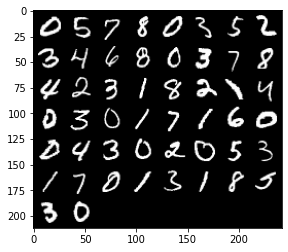

In [70]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
  
# show images
imshow(torchvision.utils.make_grid(images))

In [71]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 20

In [72]:
class RNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(RNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [73]:
model = RNN(batch_sizes, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[-0.0717,  0.0003, -0.0355, -0.0203, -0.0443, -0.0536, -0.0685,  0.0612,
         -0.0197,  0.0524],
        [-0.0794, -0.0020, -0.0272, -0.0339, -0.0374, -0.0642, -0.0410,  0.0613,
         -0.0302,  0.0588],
        [-0.0549,  0.0585, -0.0555, -0.0200, -0.0365, -0.0459, -0.0820,  0.0994,
         -0.0715,  0.0694],
        [-0.0731,  0.0039, -0.0308, -0.0325, -0.0369, -0.0504, -0.0622,  0.0567,
         -0.0267,  0.0566],
        [-0.0828,  0.0055, -0.0252, -0.0237, -0.0370, -0.0551, -0.0583,  0.0630,
         -0.0279,  0.0505],
        [-0.0705, -0.0093, -0.0295, -0.0271, -0.0512, -0.0572, -0.0591,  0.0663,
         -0.0276,  0.0585],
        [-0.0685,  0.0062, -0.0368, -0.0271, -0.0411, -0.0478, -0.0717,  0.0561,
         -0.0146,  0.0574],
        [-0.0714, -0.0022, -0.0340, -0.0263, -0.0437, -0.0516, -0.0606,  0.0618,
         -0.0182,  0.0567],
        [-0.0627,  0.0046, -0.0277, -0.0309, -0.0364, -0.0500, -0.0721,  0.0560,
         -0.0273,  0.0612],
        [-0.0712,  

In [74]:
# construct model on cuda if available

use_cuda = torch.cuda.is_available()


# Model instance
model = RNN(batch_sizes, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [75]:
loss_list = []
count = 0

for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(train_loader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, batch_sizes)

    # store loss
    loss_list.append(train_running_loss / i)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.6645 | Train Accuracy: 78.74
Epoch:  1 | Loss: 0.2870 | Train Accuracy: 91.76
Epoch:  2 | Loss: 0.2182 | Train Accuracy: 93.81
Epoch:  3 | Loss: 0.1844 | Train Accuracy: 94.87
Epoch:  4 | Loss: 0.1627 | Train Accuracy: 95.48
Epoch:  5 | Loss: 0.1519 | Train Accuracy: 95.91
Epoch:  6 | Loss: 0.1419 | Train Accuracy: 96.10
Epoch:  7 | Loss: 0.1372 | Train Accuracy: 96.30
Epoch:  8 | Loss: 0.1386 | Train Accuracy: 96.16
Epoch:  9 | Loss: 0.1283 | Train Accuracy: 96.52
Epoch:  10 | Loss: 0.1166 | Train Accuracy: 96.80
Epoch:  11 | Loss: 0.1210 | Train Accuracy: 96.78
Epoch:  12 | Loss: 0.1130 | Train Accuracy: 96.97
Epoch:  13 | Loss: 0.1079 | Train Accuracy: 97.08
Epoch:  14 | Loss: 0.1047 | Train Accuracy: 97.12
Epoch:  15 | Loss: 0.1047 | Train Accuracy: 97.14
Epoch:  16 | Loss: 0.1065 | Train Accuracy: 97.12
Epoch:  17 | Loss: 0.1063 | Train Accuracy: 97.13
Epoch:  18 | Loss: 0.1040 | Train Accuracy: 97.16
Epoch:  19 | Loss: 0.0998 | Train Accuracy: 97.24


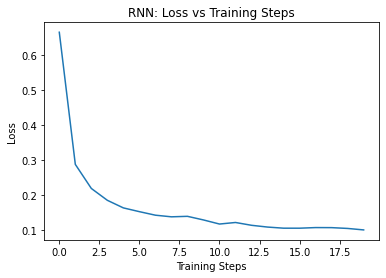

In [78]:
# visualization loss 
x_range = range(len(loss_list))
plt.plot(x_range,loss_list)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Training Steps")
plt.show()

In [79]:
val_acc = 0.0
for i, data in enumerate(val_loader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    val_acc += get_accuracy(outputs, labels, batch_sizes)
        
print('Val Accuracy: %.2f'%(val_acc/i))

Val Accuracy: 96.54
